# Question 1 - Linear Regression

## Created by Aiden Seay - CS 599 (Deep Learning)

### Notebook Setup

In [ ]:
"""
Import necessary packages
"""

# necessary imports
import time
import tensorflow as tf
import matplotlib.pyplot as plt

"""
Complete checks to ensure status of TensorFlow
"""

# ensure eager execution
print("Eager execution:", tf.executing_eagerly())

# check if GPU is available on system
device_name = tf.config.list_physical_devices("GPU")

if(device_name):
    print(f"GPU Available: {device_name}")
else:
    print("CPU Only")

Eager execution: True
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Data Creation and Model

In [51]:
def create_true_dataset(num_pts = 500, seed = None, noise_std = 1.0):

    """
    Definition: creates a true linear dataset following the function
                y = 3x + 2 + noise.

    Inputs: num_pts (int) - the number of data points in the dataset.
            seed (int) - the seed for easy reproducibility
            noise_std (float) - the amount of noise in the data
                                0.0 = no noise
                                1.0 = moderate noise
                                5.0 = a lot of noise

    Outputs: X_TRUE (tensor) - a vector of true x values.
             Y_TRUE (tensor) - a vector of true y values.
    """

    # set seed if exists for consistent tests
    if seed:
        tf.random.set_seed(seed)
    
    # generate random true x values 
    X_TRUE = tf.random.normal([num_pts])

    # generate a random amount of noise with a specified strength
    noise = tf.random.normal([num_pts], stddev = noise_std)

    # return true x and y values
    return X_TRUE, X_TRUE * 3 + 2 + noise

def y_prediction(weight, X_TRUE, bias):

    """
    Definition: predicts the true y values based on predefined weights and
                biases.

    Inputs: weight (tensor) - weights scalar used to predict the y result.
            X_TRUE (tensor) - the true x input values to predict y.
            bias (tensor) - the scalar bias used as the y-int.
            
    Outputs: Y_PRED (tensor) - the predicted y values.
    """

    # return the predicted y values
    return weight * X_TRUE + bias

### Loss Functions

In [52]:
def l1_loss(Y_TRUE, Y_PRED):

    """
    Definition: calculates the loss (L1) function comparing the 
                true values with the predicted values. The equation is
                L1 = avg(|Y_TRUE - Y_PRED|).

    Inputs: Y_TRUE (tensor) - the true y values used for training.
            Y_PRED (tensor) - the predicted y values.

    Outputs: loss (tensor) - the scalar of all loss values averaged.
    """

    # return the L1 loss function
    return tf.reduce_mean(tf.abs(Y_TRUE - Y_PRED))

def l2_loss(Y_TRUE, Y_PRED):

    """
    Definition: calculates the squared loss (L2) function or MSE comparing the 
                true values with the predicted values. The equation is
                MSE_loss = avg((Y_TRUE - Y_PRED)^2).

    Inputs: Y_TRUE (tensor) - the true y values used for training.
            Y_PRED (tensor) - the predicted y values.

    Outputs: loss (tensor) - the scalar of all loss values averaged.
    """

    # return the L2 loss function
    return tf.reduce_mean(tf.square(Y_TRUE - Y_PRED))

def hybrid_loss(Y_TRUE, Y_PRED, m = 0.5):

    """
    Definition: calculates a hybrid loss function combining L1 and L2 loss
                methods The equation is hybrid_loss = L1 + L2.

    Inputs: Y_TRUE (tensor) - the true y values used for training.
            Y_PRED (tensor) - the predicted y values.
            m (float) - the balance between L1 and L2 calculations. the default 
                        is 1/2 so L1 and L2 have an equal balance.
                         
    Outputs: loss (tensor) - the scalar of all loss values averaged.
    """
    
    # return a hybrid combination of L1 and L2 loss functions
    return m * l1_loss(Y_TRUE, Y_PRED) + (1 - m) * l2_loss(Y_TRUE, Y_PRED)

### Model Training

In [67]:
def run_model(loss_fn,
              learning_rate = 0.001,
              train_steps = 1000,
              init_weight = 1.0,
              init_bias = 1.0,
              patience_lim = 10,
              noise_std = 1.0,
              weight_noise = 0.0,
              lr_noise = 0.0,
              seed = None,
              device = "/CPU:0"):
    
    """
    Definition: This is the main function that will run the model and gives the
                user the ability to make multiple changes to the model for
                testing purposes.

    Inputs: loss_fn (str) - the name of the function used to calculate loss.
                            There are multiple loss functions that can be used
                            - L1 Loss
                            - L2 Loss
                            - Hybrid Loss
            learning_rate (float) - controls the step size of the gradient 
                                    descent.
            train_steps (int) - the number of times each data point is passed 
                                through
            init_weight (float) - the initial weight for the model
            init_bias (float) - the initial bias for the model
            patience_lim (int) - the number of epochs before using patience 
                                 scheduling
            noise_std (float) - the amount of noise in the data
            weight_noise (float) - the amount of noise in the weights
            lr_noise (float) - the amount of noise in the learning rate
            seed (int) - the seed to guarantee repeatable results
            device (str) - device computer is using either CPU or GPU
            
    Outputs:
    """

    # display status message
    print(f"Running model on {device} with Seed: {seed}")

    # initialize variables
    X_TRUE, Y_TRUE = create_true_dataset(500, noise_std=noise_std, seed=seed)
    weight = tf.Variable(init_weight, dtype=tf.float32)
    bias = tf.Variable(init_bias, dtype=tf.float32)

    # initialize epoch tracking variables
    losses = []
    best_loss = float("inf")
    patience_count = 0

    # select device to use for training
    with tf.device(device):

        # start training timer
        start_time = time.time()

        # iterate through each training step
        for epoch in range(train_steps):

            # compute the loss
            with tf.GradientTape() as tape:

                # add noise to the weight and learning rate
                noisy_weight = weight + tf.random.normal([]) * weight_noise
                noisy_lr = learning_rate + tf.random.normal([]) * lr_noise

                Y_PRED = y_prediction(noisy_weight, X_TRUE, bias)
                loss = loss_fn(Y_TRUE, Y_PRED)
            d_weight, d_bias = tape.gradient(loss, [weight, bias])

            # update parameters
            weight.assign_sub(noisy_lr * d_weight)
            bias.assign_sub(noisy_lr * d_bias)
            losses.append(loss.numpy())

            # update to track the best (the lowest) loss
            if loss.numpy() + 1e-6 < best_loss:
                best_loss = loss.numpy()
                patience_count = 0

            else:
                patience_count += 1

                # check if need to enact patience scheduling
                if patience_count >= patience_lim:

                    # reduce learning rate by half
                    learning_rate *= 0.5
                    patience_count = 0
        
        # calculate total training time
        total_time = time.time() - start_time

    # display final weight, bias, and time
    print(f"Weight: {weight.numpy()}, Bias: {bias.numpy()}, Time: {total_time}")

    return (weight.numpy(), bias.numpy(), total_time, 
            train_steps, Y_PRED.numpy(), Y_TRUE.numpy(),
            X_TRUE.numpy(), losses)

### Evaluate Results

Running model on /CPU:0 with Seed: 123456
Weight: 2.6084444522857666, Bias: 1.8361318111419678, Time: 4.453228235244751


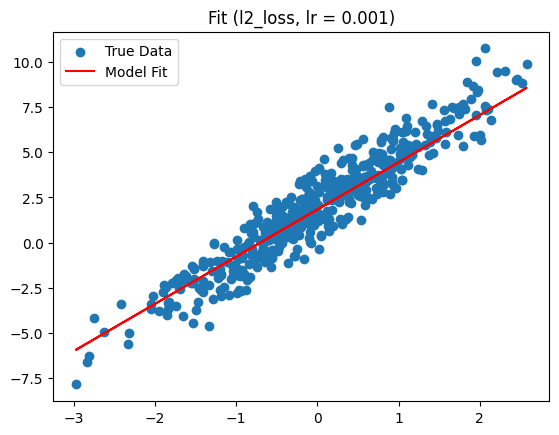

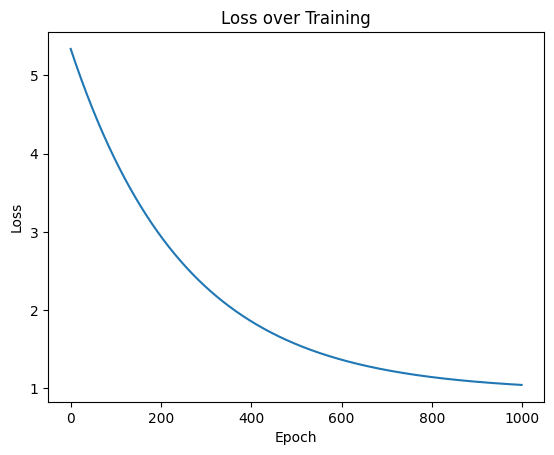

In [75]:
# run the model
(weight, bias, total_time, 
 train_steps, y_pred, y_true,
 x_true, losses) = run_model(l2_loss,
                    learning_rate = 0.001,
                    train_steps = 1000,
                    init_weight = 1.0,
                    init_bias = 1.0,
                    patience_lim = 50,
                    noise_std = 1.0,
                    weight_noise = 0.0,
                    lr_noise = 0.0,
                    seed = 123456,
                    device = "/CPU:0")

# plot the fit
plt.figure()
plt.scatter(x_true, y_true, label= "True Data")
plt.plot(x_true, y_prediction(weight, x_true, bias), 
         label = "Model Fit", color = "red")
plt.title(f"Fit (l2_loss, lr = 0.001)")
plt.legend()
plt.show()

# plot loss curve
plt.figure()
plt.plot(losses)
plt.title("Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
